In [66]:
from qiskit import Aer
Aer.backends()

[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator_statevector'),
 AerSimulator('aer_simulator_density_matrix'),
 AerSimulator('aer_simulator_stabilizer'),
 AerSimulator('aer_simulator_matrix_product_state'),
 AerSimulator('aer_simulator_extended_stabilizer'),
 AerSimulator('aer_simulator_unitary'),
 AerSimulator('aer_simulator_superop'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator'),
 PulseSimulator('pulse_simulator')]

In [1]:
import numpy as np
from collections import Counter
from qiskit import IBMQ,Aer,schedule, execute, QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.tools.visualization import plot_histogram
from qiskit.visualization import timeline_drawer
from qiskit.visualization.pulse_v2 import draw, IQXDebugging
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import AerSimulator
import qiskit.quantum_info as qi
from qiskit.providers.aer.noise import QuantumError, ReadoutError

# Tomography functions
from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library import StateTomography


# Seeds
from numpy.random import Generator, PCG64
rng = Generator(PCG64(1897))
MY_SEEDS = rng.integers(0,high=10**8,size=100)


import KSEM
from importlib import reload  
KSEM = reload(KSEM)
from KSEM import KSQS, EMLearn

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# plt.rcParams['text.usetex'] = True
fig_size = (8,6)
fig_dpi = 150

In [2]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
provider = IBMQ.get_provider(hub="ibm-q-pnnl", group="internal", project="default")
name = "ibmq_mumbai"
backend = provider.get_backend(name)
backend_noise_model = NoiseModel.from_backend(backend)
# # Remove readout errros
# p0given1 = 0
# p1given0 = 1
# rde = ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])
# for i in range(backend.configuration().num_qubits):
#     backend_noise_model._local_readout_errors[(i,)] = rde
den_simu = AerSimulator(method='density_matrix',noise_model=backend_noise_model)

n_qubits = 3
reps = 8
max_num_itrs = 10

/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (273231.95206578437 > 2 * 105311.04762268423). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (200785.20694421077 > 2 * 85474.37380520902). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value

In [4]:
backend_noise_model.to_dict()['errors'][-1]

{'type': 'roerror',
 'operations': ['measure'],
 'probabilities': [[0.9916, 0.0084], [0.031200000000000006, 0.9688]],
 'gate_qubits': [(26,)]}

In [5]:
print(backend.properties().to_dict()[ 'last_update_date'])

2022-09-27 08:40:30-04:00


In [6]:
from qiskit.visualization import plot_error_map, plot_gate_map
%matplotlib inline

# plot_error_map(backend, figsize=(18, 12))

In [7]:
from qiskit import Aer
def single_iter(n_qubits=2):
    iterate = QuantumCircuit(n_qubits)
    iterate.h(0)
    iterate.cx(0,1)
    iterate.cx(1,2)
    iterate.barrier()
    iterate.cx(1,2)
    iterate.cx(0,1)
    iterate.h(0)
    iterate.barrier()
    return iterate

def iterative_circ(num_itrs, n_qubits=2, save_den = True):   
    total_circ = QuantumCircuit(n_qubits)
    for i in range(num_itrs):
        total_circ.compose(single_iter(n_qubits), inplace=True)
    if save_den:
        total_circ.save_density_matrix(pershot=False)
    total_circ.measure_all()
    return total_circ

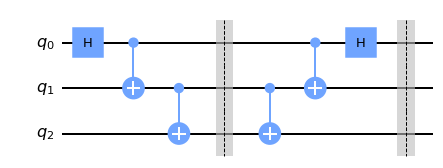

In [8]:
single_iter(n_qubits).draw("mpl")

10


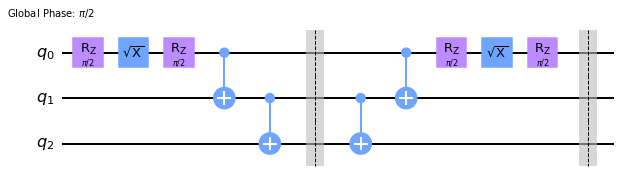

In [9]:
temp_circ = transpile(single_iter(n_qubits), backend=den_simu)
print(temp_circ.depth())
temp_circ.draw("mpl")

In [10]:
temp_circ2 = iterative_circ(max_num_itrs, n_qubits, save_den = False)
temp_circ3 = transpile(temp_circ2, backend=backend)
print("Depth:", temp_circ3.depth())
print("T1:", backend.properties().qubit_property(0)['T1'][0], "sec")
print("T2:", backend.properties().qubit_property(0)['T2'][0], "sec")
dt = backend.configuration().dt # sec
temp_sch = schedule(temp_circ3, backend)
print("Circuit Operation Time:",(temp_sch.stop_time - temp_sch.start_time)*dt, "sec")

Depth: 101
T1: 0.00011842442381040724 sec
T2: 2.4572795768493453e-05 sec
Circuit Operation Time: 2.7445333333333333e-05 sec


## Qiskit Backend-noise Simulation

Obtain measurement data and actual quantum states (from a backend-noise simulator)

Note that the outputs does not have measurement noise because the probabilities are obtained from density matrix object, instead of measurement operator API.

In [11]:
unitary_simulator = Aer.get_backend('aer_simulator')
unitary_circ = transpile(single_iter(n_qubits), backend=den_simu)
unitary_circ.save_unitary()
unitary_result = unitary_simulator.run(unitary_circ).result()
unitary = unitary_result.get_unitary(unitary_circ)

unitaries = []
for i in range(1, max_num_itrs+1):
    gate = unitary.data
    F = np.kron(gate.conjugate(), gate)
    unitaries.append(F)

In [12]:
trans_circ = transpile(iterative_circ(3, n_qubits), backend=den_simu)
iter_res = den_simu.run(trans_circ,shots=8192*reps,seed_simulator=np.random.randint(10**8)).result()
iter_res.get_counts()

{'001': 5678,
 '101': 634,
 '010': 2214,
 '110': 672,
 '100': 1153,
 '111': 612,
 '000': 52666,
 '011': 1907}

In [13]:
total_simu_dens = [] # quantum state in density-matrix form
total_simu_probs = [] # measurement result
total_simu_purs = [] # purity
for i in range(1, max_num_itrs+1):
    my_seed = MY_SEEDS[i]
    trans_circ = transpile(iterative_circ(i, n_qubits, save_den = True), seed_transpiler=my_seed, backend=den_simu,optimization_level=0)
    iter_res = den_simu.run(trans_circ,shots=8192*reps,seed_simulator=my_seed).result()
    iter_den = iter_res.data()['density_matrix']
    total_simu_dens.append(iter_den)
    
    trans_circ = transpile(iterative_circ(i, n_qubits, save_den = False), seed_transpiler=my_seed, backend=den_simu,optimization_level=0)
    iter_res = den_simu.run(trans_circ,shots=8192*reps,seed_simulator=my_seed).result()
    total_simu_probs.append(KSEM.dictToVec(iter_res.get_counts()))
    total_simu_purs.append(np.real(iter_den.purity()))
    
print("Purity")
for pu in total_simu_purs:
    print(pu)
    
print("\nProb Vec")
for p in total_simu_probs:
    print(p)

Purity
0.8800490040492603
0.7788951212202726
0.6934731911817104
0.6212279818531993
0.5600283426477846
0.5080959249035649
0.4639459836873945
0.42633820109874926
0.39423582393646894
0.36677170072753984

Prob Vec
[0.90660095 0.04263306 0.01765442 0.01052856 0.01179504 0.00346375
 0.0037384  0.00358582]
[0.853302   0.06517029 0.02661133 0.02029419 0.01402283 0.00712585
 0.00682068 0.00665283]
[0.79870605 0.0874176  0.03518677 0.03067017 0.01745605 0.01060486
 0.00991821 0.01004028]
[0.75486755 0.10636902 0.04275513 0.03755188 0.01925659 0.01263428
 0.01344299 0.01312256]
[0.71157837 0.1254425  0.04966736 0.04464722 0.02137756 0.01647949
 0.01516724 0.01564026]
[0.67410278 0.13531494 0.05671692 0.05404663 0.02461243 0.0186615
 0.01815796 0.01838684]
[0.64120483 0.14700317 0.06268311 0.05775452 0.02735901 0.02171326
 0.02203369 0.02024841]
[0.60839844 0.15983582 0.06822205 0.06533813 0.02806091 0.02383423
 0.02348328 0.02282715]
[0.57388306 0.17086792 0.07542419 0.07087708 0.03179932 0.02546

## State Tomography

### Use a Noise Model without Measurement Error for Tomography

In [36]:
backend_noise_model_for_tomo = NoiseModel.from_backend(backend)
# # Remove readout errros
# p0given1 = 0
# p1given0 = 0
# rde = ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])
# for i in range(backend.configuration().num_qubits):
#     backend_noise_model_for_tomo._local_readout_errors[(i,)] = rde
den_simu_for_tomo = AerSimulator(method='density_matrix',noise_model=backend_noise_model_for_tomo)

/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (273231.95206578437 > 2 * 105311.04762268423). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (200785.20694421077 > 2 * 85474.37380520902). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value

In [37]:
tomo_dens = [] # quantum state in density-matrix form
tomo_probs = [] # measurement result
tomo_purs = [] # purity
for i in range(1, max_num_itrs+1):
    my_seed = MY_SEEDS[i]
    tomo_target_circ = transpile(iterative_circ(i, n_qubits, save_den = False), seed_transpiler=my_seed, backend=den_simu_for_tomo,optimization_level=0)
    qstexp = StateTomography(tomo_target_circ)
    qstdata = qstexp.run(den_simu, seed_simulation=my_seed).block_for_results()
    tomo_state =  qstdata.analysis_results("state")
    
    tomo_dens.append(tomo_state.value.data)
    tomo_probs.append(tomo_state.value.probabilities())
    tomo_purs.append(np.real(tomo_state.value.purity()))
    
print("Tomography Purity")
for pu in tomo_purs:
    print(pu)
    
print("\nTomography Prob Vec")
for p in tomo_probs:
    print(p)

Tomography Purity
0.8228457580886639
0.7306197672990079
0.6476286926119963
0.5735471131267398
0.5292109383477112
0.47492326336142476
0.4372238347559807
0.4020554931075493
0.36582489955572534
0.34632922984935705

Tomography Prob Vec
[0.90462626 0.03692099 0.0157432  0.01230424 0.01378838 0.00515102
 0.0056807  0.00578521]
[0.85010898 0.06198499 0.02665808 0.02155419 0.01663512 0.01079875
 0.00663432 0.00562557]
[0.79562198 0.08463693 0.03780074 0.03114425 0.01901091 0.01222666
 0.01180186 0.00775666]
[0.74412245 0.1049339  0.04871905 0.03837969 0.02706541 0.01490329
 0.00974135 0.01213485]
[0.70890299 0.12258572 0.04928928 0.04956055 0.02286784 0.01304796
 0.01657444 0.01717122]
[0.66552734 0.13905165 0.06282552 0.0500217  0.02680122 0.01920573
 0.01915148 0.01741536]
[0.63194444 0.15874566 0.06732856 0.05474175 0.02907986 0.01746962
 0.02045356 0.02023655]
[0.5973036  0.16880968 0.0730523  0.06448025 0.03415256 0.02297635
 0.01934136 0.0198839 ]
[0.56032986 0.17865668 0.08658854 0.0646

## Kalman Smoother

In [16]:
def vecden_meas(state):# H, measurement matrix for vectorized density matrix
    num_qubits = int(np.log2(np.sqrt(state.shape[0])))
    nrows = 2**num_qubits
    ncols = nrows**2
    mat = np.zeros((nrows, ncols), dtype=np.float64)
    for k in range(nrows):
        mat[k, nrows*k+k] = 1.0 # take out the diagonal terms in vectorized density matrix
    return np.real(mat.dot(state))

### Initialize

In [17]:
initial_state = np.array([0]*(total_simu_probs[0].size**2), dtype=complex)
initial_state[0] = 1

# initial state
num_dim = initial_state.size
x =initial_state
x[0]-= 0.01/num_dim
nrows = int(x.size-1)
for k in range(1,nrows+1):
    x[k] += 1/(num_dim*nrows)

In [18]:
# Other variance parameters
num_dim_state = initial_state.size
num_dim_obs = total_simu_probs[0].size

M = np.identity(num_dim_state, dtype=complex)* 0.01 * (1) # a guess for covariance matrix, E[(x0-xhat0^+)(x0-xhat0^+)^T]
Q = np.identity(num_dim_state, dtype=complex)* 0.2 * (1) # state covariance
R = np.identity(num_dim_obs)* 0.2 * (1) # meas covariance
P = np.identity(num_dim_state, dtype=complex)* 0.1 * (1)# 
# U = np.identity(num_dim_obs, dtype=complex)* 0.0

In [19]:
x.size,num_dim_state,num_dim_obs, unitaries[0].size

(64, 64, 8, 4096)

### EM and Smoother - Total

Use longest iterations

In [43]:
total_smoother_dens = []
total_smoother_purs = []

observs = total_simu_probs
learn_obj = EMLearn(observs, unitaries[0], x, M, Q, R, P)
estX0, estM0, estQ, estR, estF = learn_obj.learn() # they are all arguemented

# Slice from argumented system
realX0 = estX0.toarray()[:num_dim_state]
realX0 = realX0.flatten().reshape((int(np.sqrt(num_dim_state)), int(np.sqrt(num_dim_state))), order='F') # to matrix
realX0 = KSEM.closed_den_mat(realX0) # find closest valid density matrix
realX0 = np.array(realX0.flatten(order='C'))[0] # reshape to vector

realM0 = estM0.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
realF = estF.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
realQ = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
realR = estR.toarray()[range(num_dim_obs),:][:,range(num_dim_obs)]
realP = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state, 2*num_dim_state)]

smoother = KSQS(observs, realF, realX0, realM0, realQ, realR, realP)
x_seq, M_seq, M_prio_seq = smoother.smooth() 



# x_est_norms = []
# for j in range(max_num_itrs):
#     x_est = np.array(x_seq[j+1][:num_dim_state].todense()).flatten()
#     diag_sum = np.sum(vecden_meas(x_est))

#     #normalize along the diagonal
#     x_est_norm = x_est+0
#     nrows = int(np.sqrt(x_est.size))
#     for k in range(nrows):
#         x_est_norm[k*nrows+k] = x_est_norm[k*nrows+k]/diag_sum
#     x_est_norms.append(x_est_norm)
#     final_den = x_est_norm.reshape(num_dim_obs, num_dim_obs)
#     total_smoother_dens.append(final_den)
#     total_smoother_purs.append(np.real(qi.DensityMatrix(final_den).purity()))
for j in range(max_num_itrs):
    x_est = np.matrix(x_seq[j+1][:num_dim_state].todense()).flatten().reshape((num_dim_obs, num_dim_obs), order='F')
#     x_est = (x_est+x_est.H)/2
    final_den = KSEM.closed_den_mat(x_est)
    total_smoother_dens.append(final_den)
    total_smoother_purs.append(np.real(qi.DensityMatrix(final_den).purity()))

/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


Iteration statrts New ll 777.12, Last ll 767.12
Iteration     1, New log-likelihood 8.33626e+02, Last log-likelihood 7.77116e+02, Change 5.65100e+01
Iteration     2, New log-likelihood 8.88668e+02, Last log-likelihood 8.33626e+02, Change 5.50424e+01
Iteration     3, New log-likelihood 9.43218e+02, Last log-likelihood 8.88668e+02, Change 5.45496e+01
Iteration     4, New log-likelihood 9.97182e+02, Last log-likelihood 9.43218e+02, Change 5.39644e+01
Iteration     5, New log-likelihood 1.05040e+03, Last log-likelihood 9.97182e+02, Change 5.32175e+01
Iteration     6, New log-likelihood 1.10277e+03, Last log-likelihood 1.05040e+03, Change 5.23663e+01
Iteration     7, New log-likelihood 1.15425e+03, Last log-likelihood 1.10277e+03, Change 5.14886e+01
Iteration     8, New log-likelihood 1.20492e+03, Last log-likelihood 1.15425e+03, Change 5.06658e+01
Iteration     9, New log-likelihood 1.25497e+03, Last log-likelihood 1.20492e+03, Change 5.00487e+01
Iteration    10, New log-likelihood 1.15421

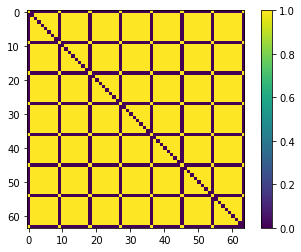

In [44]:
plt.imshow(realQ.real<0)
plt.colorbar()
plt.show()

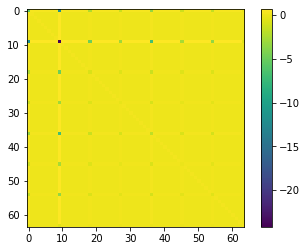

In [45]:
plt.imshow(realQ.real)
plt.colorbar()
plt.show()

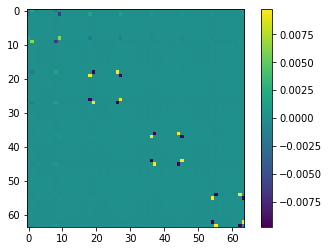

In [46]:
plt.imshow(realQ.imag)
plt.colorbar()
plt.show()

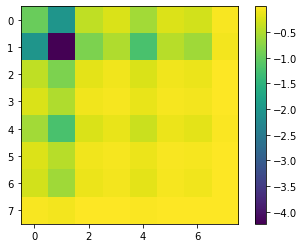

In [47]:
plt.imshow(realR.real)
plt.colorbar()
plt.show()

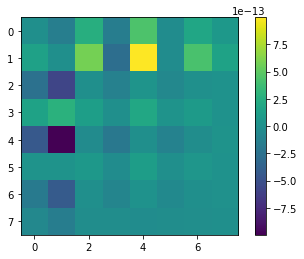

In [48]:
plt.imshow(realR.imag)
plt.colorbar()
plt.show()

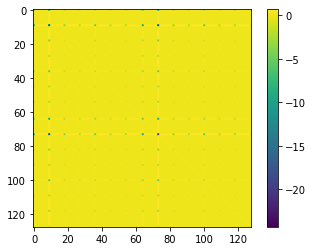

In [64]:
plt.imshow(estQ.toarray().real)
plt.colorbar()
plt.show()

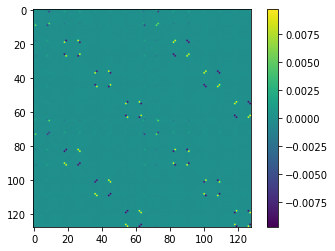

In [65]:
plt.imshow(estQ.toarray().imag)
plt.colorbar()
plt.show()

Only use the estimation in the final iteration as the valid output

In [49]:
# total_smoother_dens = []
# total_smoother_purs = []
# for i in range(1,max_num_itrs+1):
#     print("Circuit Iteration", i)
#     observs = total_simu_probs[0:i]
#     learn_obj = EMLearn(observs, unitaries[0], x, M, Q, R, P)
#     estX0, estM0, estQ, estR, estF = learn_obj.learn() # they are all arguemented
    
#     # Slice from argumented system
#     realX0 = estX0.toarray()[:num_dim_state]
#     realX0norm = np.sqrt(np.sum(np.abs(realX0)**2))
#     realM0 = estM0.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
#     realF = estF.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
#     realQ = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
#     realR = estR.toarray()[range(num_dim_obs),:][:,range(num_dim_obs)]
#     realP = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state, 2*num_dim_state)]

#     smoother = KSQS(observs, realF, realX0, realM0, realQ, realR, realP)
#     x_seq, M_seq, M_prio_seq = smoother.smooth() 
    
    
#     # Normalization
# #     x_est_norms = []
# #     for j in range(i):
# #         x_est = np.array(x_seq[j+1][:num_dim_state].todense()).flatten()
# #         diag_sum = np.sum(vecden_meas(x_est))

# #         #normalize along the diagonal
# #         x_est_norm = x_est+0
# #         nrows = int(np.sqrt(x_est.size))
# #         for k in range(nrows):
# #             x_est_norm[k*nrows+k] = x_est_norm[k*nrows+k]/diag_sum
# #     final_den = x_est_norm.reshape(num_dim_obs, num_dim_obs)

#     x_est = np.matrix(x_seq[-1][:num_dim_state].todense()).flatten().reshape((num_dim_obs, num_dim_obs), order='F')
# #     x_est = (x_est+x_est.H)/2
#     final_den = KSEM.closed_den_mat(x_est)
#     total_smoother_dens.append(final_den)
#     total_smoother_purs.append(np.real(qi.DensityMatrix(final_den).purity()))

In [50]:
for den in total_smoother_dens:
    print("Is state a valid density matrix:", qi.DensityMatrix(den).is_valid())

Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True


In [51]:
total_smoother_dens[0].diagonal().flatten()

matrix([[0.8669451 -4.44453588e-26j, 0.06307539+9.88507472e-27j,
         0.02211894-1.75936267e-21j, 0.0053738 -4.47511033e-21j,
         0.01404836+1.45406451e-22j, 0.01685742+5.88696108e-22j,
         0.00507855+0.00000000e+00j, 0.00650243+0.00000000e+00j]])

In [52]:
np.diag(np.array(total_smoother_dens[0].diagonal()).flatten())

array([[0.8669451 -4.44453588e-26j, 0.        +0.00000000e+00j,
        0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
        0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
        0.        +0.00000000e+00j, 0.        +0.00000000e+00j],
       [0.        +0.00000000e+00j, 0.06307539+9.88507472e-27j,
        0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
        0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
        0.        +0.00000000e+00j, 0.        +0.00000000e+00j],
       [0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
        0.02211894-1.75936267e-21j, 0.        +0.00000000e+00j,
        0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
        0.        +0.00000000e+00j, 0.        +0.00000000e+00j],
       [0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
        0.        +0.00000000e+00j, 0.0053738 -4.47511033e-21j,
        0.        +0.00000000e+00j, 0.        +0.00000000e+00j,
        0.        +0.00000000e+00j, 0

In [53]:
with np.printoptions(precision=3, suppress=True):
    for den in total_smoother_dens:
        non_diag_den = den - np.diag(np.array(den.diagonal()).flatten())
        print(np.linalg.norm(non_diag_den))
#     print(total_smoother_dens[8])
#     print(total_simu_dens[8].data)

0.008263773618153971
0.026210015936463864
0.04441668033958082
0.05969236935420678
0.07267161274673331
0.08285105882800128
0.08970836642936114
0.09777235434993958
0.1040038281637828
0.10776562247180896


In [54]:
print("Estimated Purity (Total)")
for pu in total_smoother_purs:
    print(pu)

Estimated Purity (Total)
0.7567083334534049
0.7175403978113927
0.6491026420732002
0.5790409822157647
0.5241238100776366
0.47213491237048505
0.4304505703453904
0.39721162852641007
0.3674677589785652
0.35003797360781236


## Check the fidelity between estimated state and the real state in the simulator

In [55]:
from scipy.linalg import sqrtm
def state_fid(m1,m2):
    sqm1 = sqrtm(m1)
    temp = sqm1.dot(m2).dot(sqm1)
    temp2 = sqrtm(temp)
    return np.real(np.trace(temp2))**2

Iteration 1 KS Fid: 0.9762455434668303 Tomo Fid: 0.9673870135190993
Iteration 2 KS Fid: 0.9766537458642922 Tomo Fid: 0.9657936254973315
Iteration 3 KS Fid: 0.948317648486097 Tomo Fid: 0.9625514626161473
Iteration 4 KS Fid: 0.9382530695178821 Tomo Fid: 0.9684910797692563
Iteration 5 KS Fid: 0.9297116034070664 Tomo Fid: 0.9619227151316582
Iteration 6 KS Fid: 0.922890724490545 Tomo Fid: 0.983269172259185
Iteration 7 KS Fid: 0.9088453193517542 Tomo Fid: 0.9748547208838519
Iteration 8 KS Fid: 0.8991177481655944 Tomo Fid: 0.9776552022269972
Iteration 9 KS Fid: 0.8975304745688698 Tomo Fid: 0.96762503106018
Iteration 10 KS Fid: 0.9046088137888681 Tomo Fid: 0.9767672527108751


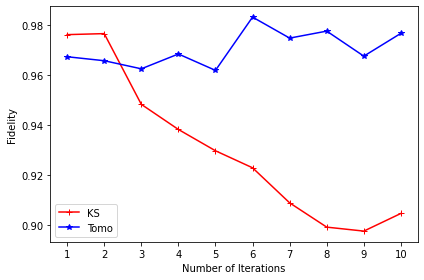

In [56]:
# Compare fidelity, use Qiskit API (when every state from KS is a valid density matrix)
diff_fed_all= []
diff_fed_tomo= []
for i in range(max_num_itrs):
    qis_den_tomo = qi.DensityMatrix(tomo_dens[i])
    qis_den_all = qi.DensityMatrix(total_smoother_dens[i])
    fed_difference_tomo =  qi.state_fidelity(total_simu_dens[i], qis_den_tomo)
    fed_difference_all =  qi.state_fidelity(total_simu_dens[i], qis_den_all)
    diff_fed_all.append(fed_difference_all)
    diff_fed_tomo.append(fed_difference_tomo)
    print("Iteration",i+1, "KS Fid:", fed_difference_all, "Tomo Fid:", fed_difference_tomo)
    
iter_range = range(max_num_itrs)
plt.plot(np.array(iter_range)+1, np.array(diff_fed_all)[iter_range], '+-', color='red', label='KS')
plt.plot(np.array(iter_range)+1, np.array(diff_fed_tomo)[iter_range], '*-', color='blue', label='Tomo')
# plt.plot(np.array(iter_range)+1, np.array([0.9]*max_num_itrs)[iter_range], '--', color='lightgray')
plt.xlabel("Number of Iterations")
plt.ylabel("Fidelity")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
# plt.savefig("diff_fed_qis.svg")
plt.show()

Iteration 1 KS Fid: 0.9762455434668336 Tomo Fid: 0.9673870131844156
Iteration 2 KS Fid: 0.976653745858925 Tomo Fid: 0.9657936257095958
Iteration 3 KS Fid: 0.9483176489781293 Tomo Fid: 0.9625514626290913
Iteration 4 KS Fid: 0.9382530693910358 Tomo Fid: 0.9684910800539568
Iteration 5 KS Fid: 0.9297116033363306 Tomo Fid: 0.9619227151316584
Iteration 6 KS Fid: 0.9228907242463266 Tomo Fid: 0.9832691722591861
Iteration 7 KS Fid: 0.9088453200753199 Tomo Fid: 0.9748547208838524
Iteration 8 KS Fid: 0.8991177476412383 Tomo Fid: 0.977655202226999
Iteration 9 KS Fid: 0.8975304752636638 Tomo Fid: 0.9676250310601808
Iteration 10 KS Fid: 0.9046088141781725 Tomo Fid: 0.9767672527108757


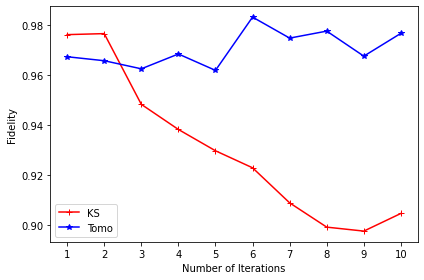

In [57]:
# Compare fidelity, use my own function (when some states from KS are not valid density matrices)
diff_fed_all= []
diff_fed_tomo= []
for i in range(max_num_itrs):
    fed_difference_tomo =  state_fid(total_simu_dens[i].data, tomo_dens[i])
    fed_difference_all =  state_fid(total_simu_dens[i].data, total_smoother_dens[i])
    diff_fed_all.append(fed_difference_all)
    diff_fed_tomo.append(fed_difference_tomo)
    print("Iteration",i+1, "KS Fid:", fed_difference_all, "Tomo Fid:", fed_difference_tomo)
    
iter_range = range(max_num_itrs)
plt.plot(np.array(iter_range)+1, np.array(diff_fed_all)[iter_range], '+-', color='red', label='KS')
plt.plot(np.array(iter_range)+1, np.array(diff_fed_tomo)[iter_range], '*-', color='blue', label='Tomo')
# plt.plot(np.array(iter_range)+1, np.array([0.9]*max_num_itrs)[iter_range], '--', color='lightgray')
plt.xlabel("Number of Iterations")
plt.ylabel("Fidelity")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
# plt.savefig("diff_fed.svg")
plt.show()

Iteration 1 KS Norm: 0.08287992304660097 Tomo Norm: 0.06339010264020423
Iteration 2 KS Norm: 0.05593636096379154 Tomo Norm: 0.06498128880318807
Iteration 3 KS Norm: 0.08863856081648458 Tomo Norm: 0.08338900224090086
Iteration 4 KS Norm: 0.10685368305300752 Tomo Norm: 0.07676223703723416
Iteration 5 KS Norm: 0.12156924667027806 Tomo Norm: 0.09355857617701288
Iteration 6 KS Norm: 0.13361851610005823 Tomo Norm: 0.08386833771331356
Iteration 7 KS Norm: 0.1458395927745326 Tomo Norm: 0.09265861859577786
Iteration 8 KS Norm: 0.15616960578451664 Tomo Norm: 0.0997247840442971
Iteration 9 KS Norm: 0.16273035048240803 Tomo Norm: 0.10666165164861062
Iteration 10 KS Norm: 0.1637584405026453 Tomo Norm: 0.10494800258173036


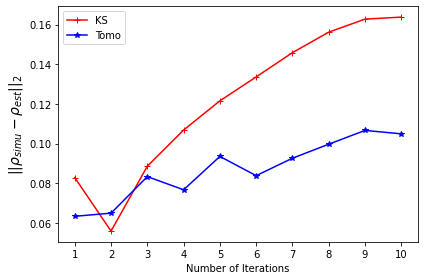

In [58]:
diff_norm_all= []
diff_norm_tomo= []
for i in range(max_num_itrs):
    norm_difference_tomo =  np.linalg.norm(total_simu_dens[i].data-tomo_dens[i])
    norm_difference_all =  np.linalg.norm(total_simu_dens[i].data-total_smoother_dens[i])
    diff_norm_all.append(norm_difference_all)
    diff_norm_tomo.append(norm_difference_tomo)
    print("Iteration",i+1, "KS Norm:", norm_difference_all, "Tomo Norm:", norm_difference_tomo)
    
iter_range = range(max_num_itrs)
plt.plot(np.array(iter_range)+1, np.array(diff_norm_all)[iter_range], '+-', color='red', label='KS')
plt.plot(np.array(iter_range)+1, np.array(diff_norm_tomo)[iter_range], '*-', color='blue', label='Tomo')
plt.xlabel("Number of Iterations")
plt.ylabel(r'$||\rho_{simu} - \rho_{est}||_2$', fontsize=14)
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
# plt.savefig("diff_norm.svg")
plt.show()